# Load DeepFly3D Data

In [1]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.lifter.utils import process_dict
from liftpose.vision_3d import world_to_camera_dict, reprojection_error, intrinsic_matrix, project_to_random_eangle
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
from tqdm import tqdm
tqdm.get_lock().locks = []

# decleare data parameters
par_train = {  'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D', # change the path 
               'out_dir'        : '/data/LiftPose3D/fly_tether/angle_inv_network_errors',
               'train_subjects' : [1,2,3,4,5,6,7],
               'test_subjects'  : [8,9],
               'actions'        : ['all'],
               'cam_id'         : [0]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load 3D data
train_3d, train_keypts, rcams_train = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)

test_3d, test_keypts, rcams_test = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)


#obtain 2D data by projection
intr = intrinsic_matrix(171.0 * 94.0, 171.0 * 94.0, 240, 480)
training_kwargs = {'eangles':  {0: [[-225,-45], [-2, 2], [-2,2]], 1: [[-45,135], [-2, 2], [-2,2]]},
                   'axsorder': 'yxz', 
                   'intr': intr}

test_2d, angles = process_dict(
                    project_to_random_eangle,
                    test_3d,
                    2,
                    training_kwargs['eangles'],
                    axsorder=training_kwargs['axsorder'],
                    project=True,
                    intr=training_kwargs['intr'],
                )

angles = np.vstack(list(angles.values()))

# Train LiftPose3D Network on DeepFly3D Data

In [2]:
from liftpose.preprocess import obtain_projected_stats

stats = obtain_projected_stats(train_3d, 
                              training_kwargs['eangles'], 
                              training_kwargs['axsorder'], 
                              training_kwargs['intr'], 
                              par['roots'], 
                              par['target_sets'],
                              par['out_dir'], 
                              th=1)

[preprocess.py:499]:INFO:Expected error for obtaining projection stats: 2186.1122768009895
[preprocess.py:499]:INFO:Expected error for obtaining projection stats: 23.714418885905772
[preprocess.py:499]:INFO:Expected error for obtaining projection stats: 10.426140288071641
[preprocess.py:499]:INFO:Expected error for obtaining projection stats: 1.622623246948737
[preprocess.py:499]:INFO:Expected error for obtaining projection stats: 2.705981861446838
[preprocess.py:499]:INFO:Expected error for obtaining projection stats: 1.254307642305646
[preprocess.py:499]:INFO:Expected error for obtaining projection stats: 4.6399263510832816
[preprocess.py:499]:INFO:Expected error for obtaining projection stats: 0.8221991039989622


In [ ]:
stats = pickle.load(open('/data/LiftPose3D/fly_tether/angle_inv_network/stats.pkl','rb'))

In [4]:
from liftpose.main import train as lp3d_train
from liftpose.lifter.augmentation import random_project
aug = random_project(**training_kwargs)

lp3d_train(train_2d=None, test_2d=test_2d,
           train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts,
           test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'],
           training_kwargs={"epochs":10},
           augmentation=[aug],
           stats=stats)

[main.py:251]:INFO:Saving pre-processed 2D data at /data/LiftPose3D/fly_tether/angle_inv_network_errors/stat_2d.pth.tar.
[main.py:270]:INFO:Saving pre-processed 3D data at /data/LiftPose3D/fly_tether/angle_inv_network_errors/stat_3d.pth.tar.
[main.py:298]:INFO:Starting training model.
[main.py:308]:DEBUG:
==================Options=================
[main.py:309]:DEBUG:{   'batch_size': 64,
    'data_dir': '/data/LiftPose3D/fly_tether/angle_inv_network_errors',
    'dropout': 0.5,
    'epochs': 10,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/data/LiftPose3D/fly_tether/angle_inv_network_errors',
    'out_dir': '/data/LiftPose3D/fly_tether/angle_inv_network_errors',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:310]:DEBUG:======================================

Epoch 000 | LR  0.00090 | Loss Test  0.00000 | Loss Train  0.10263|: 100%|██████████| 5822/5822 [00:44<00:00, 131.11it/s]
Epoch 001 | LR  0.00081 | Loss Test  0.02971 | Loss Train  0.04296|: 100%|██████████| 5822/5822 [00:45<00:00, 128.51it/s]
Epoch 002 | LR  0.00073 | Loss Test  0.02369 | Loss Train  0.03838|: 100%|██████████| 5822/5822 [00:45<00:00, 128.39it/s]
Epoch 003 | LR  0.00066 | Loss Test  0.02134 | Loss Train  0.03572|: 100%|██████████| 5822/5822 [00:45<00:00, 128.80it/s]
Epoch 004 | LR  0.00059 | Loss Test  0.01965 | Loss Train  0.03404|: 100%|██████████| 5822/5822 [00:45<00:00, 127.52it/s]
Epoch 005 | LR  0.00053 | Loss Test  0.01856 | Loss Train  0.03289|: 100%|██████████| 5822/5822 [00:45<00:00, 128.30it/s]
Epoch 006 | LR  0.00043 | Loss Test  0.01797 | Loss Train  0.03199|: 100%|██████████| 5822/5822 [00:45<00:00, 127.62it/s]
Epoch 007 | LR  0.00039 | Loss Test  0.01742 | Loss Train  0.03129|: 100%|██████████| 5822/5822 [00:46<00:00, 126.27it/s]
Epoch 008 | LR  0.00035 

In [ ]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [5]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:398]:INFO:starting testing in path: /data/LiftPose3D/fly_tether/angle_inv_network_errors
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:53]:INFO:total params: 4.33M
[lift.py:61]:INFO:loading ckpt from '/data/LiftPose3D/fly_tether/angle_inv_network_errors/ckpt_best.pth.tar'
[lift.py:69]:INFO:ckpt loaded (epoch: 10 | err: 0.19107505195632035)
[lift.py:103]:INFO:Saving results: /data/LiftPose3D/fly_tether/angle_inv_network_errors/test_results.pth.tar


# Plot errors

In [6]:
from liftpose.postprocess import load_test_results
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)
error = np.abs(test_3d_gt - test_3d_pred).sum(2).mean(1)

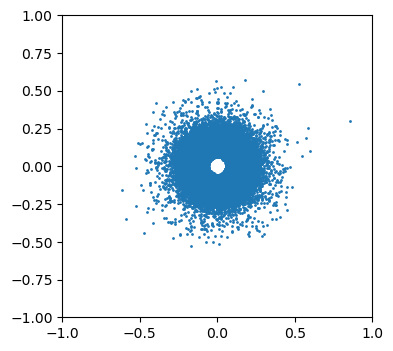

In [8]:
fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111)
x = error*np.cos(np.radians(angles[:,0]))
y = error*np.sin(np.radians(angles[:,0]))
ax.scatter(x, y, s=1)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.savefig('angle_error.svg')

In [ ]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90, azim=0)

t = 0
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=good_keypts[t],
            show_gt_always=False)